# graphTRIP demo: synthetic data and training

In this notebook, we'll demonstrate how to train a graphTRIP model on some random mock data. Specifically, we'll show how to:
1. Create mock data
2. Load a BrainGraphDataset object
3. Train a graphTRIP model with given configs

In [1]:
import sys
import os
# Ensure project root is on the path (run with kernel cwd = project root or notebooks/)
sys.path.insert(0, os.path.join(os.getcwd(), "..") if os.path.basename(os.getcwd()) == "notebooks" else os.getcwd())

from utils.files import project_root, get_filepath, get_subject_id
import numpy as np
import pandas as pd

## 1. Creating the mock data

We generate synthetic data in the same layout as real data:
- **Per subject** (S01–S10): `data/raw/mock_study/mock_session/schaefer100/<Sxx>/node.csv` and `edge.csv`.
- **One annotations file**: `data/raw/mock_study/annotations.csv` with graph-level labels (Patient, Outcome, Baseline, Condition).

Node files have three features (X1, X2, X3); edge files have one feature (`random_corrs`), a flattened 100×100 correlation matrix per subject.

In [2]:
def make_random_correlation_matrix(n, rng):
    """Returns an n×n valid correlation matrix (symmetric, diagonal 1)."""
    A = rng.standard_normal((n, n))
    return np.corrcoef(A).astype(np.float64)


def create_mock_data(
    study="mock_study",
    session="mock_session",
    atlas="schaefer100",
    num_subjects=10,
    num_nodes=100,
    seed=42,
):
    """Write random node.csv, edge.csv per subject and one annotations.csv."""
    rng = np.random.default_rng(seed)
    root = os.path.join(project_root(), "data")
    base = get_filepath(root=root, study=study, session=session, atlas=atlas, subject=None)
    os.makedirs(base, exist_ok=True)

    annotations_dir = os.path.join(root, "raw", study)
    os.makedirs(annotations_dir, exist_ok=True)
    annotations = pd.DataFrame({
        "Patient": np.arange(1, num_subjects + 1, dtype=int),
        "Outcome": rng.integers(1, 26, size=num_subjects),
        "Baseline": rng.integers(1, 26, size=num_subjects),
        "Condition": 1,
    })
    annotations.to_csv(os.path.join(annotations_dir, "annotations.csv"), index=False)

    for sub in range(num_subjects):
        sub_dir = os.path.join(base, get_subject_id(sub))
        os.makedirs(sub_dir, exist_ok=True)
        node_df = pd.DataFrame({
            "X1": rng.uniform(size=num_nodes),
            "X2": rng.uniform(size=num_nodes),
            "X3": rng.uniform(size=num_nodes),
        })
        node_df.to_csv(os.path.join(sub_dir, "node.csv"), index=False)
        corr = make_random_correlation_matrix(num_nodes, rng)
        edge_df = pd.DataFrame({"random_corrs": corr.ravel(order="C")})
        edge_df.to_csv(os.path.join(sub_dir, "edge.csv"), index=False)

    print(f"Mock data written under {base} and {annotations_dir}/annotations.csv")
    return base, annotations_dir

In [3]:
base, ann_dir = create_mock_data()
print("\nAnnotations preview:")
display(pd.read_csv(os.path.join(ann_dir, "annotations.csv")))

Mock data written under /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/data/raw/mock_study/mock_session/schaefer100 and /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/data/raw/mock_study/annotations.csv

Annotations preview:


,Patient,Outcome,Baseline,Condition
0,1,3,14,1
1,2,20,25,1
2,3,17,19,1
3,4,11,20,1
4,5,11,18,1
5,6,22,20,1
6,7,3,13,1
7,8,18,4,1
8,9,6,21,1
9,10,3,12,1


## 2. Loading the dataset

We build a `BrainGraphDataset` with the same study/session/atlas and specify which node, edge, and graph attributes to use. The edge transform keeps only the top 20% of edges by correlation strength (`DensityThresholdAdjacency`). The first time you run this (or after changing raw data), use `force_reload=True` to rebuild the processed dataset on disk.

In [4]:
from datasets import BrainGraphDataset, DensityThresholdAdjacency

edge_tfm = DensityThresholdAdjacency(density=0.2, edge_info="random_corrs")
attrs = {
    "edge": ["random_corrs"],
    "node": ["X1", "X2", "X3"],
    "graph": ["Baseline"],
}
dataset = BrainGraphDataset(
    edge_tfm=edge_tfm,
    attrs=attrs,
    force_reload=True,
    atlas="schaefer100",
    study="mock_study",
    session="mock_session",
    prefilter={},
)
print(f"Loaded {len(dataset)} graphs. First graph: {dataset[0]}")

Processing...
10it [00:00, 229.24it/s]

Loaded 10 graphs. First graph: Data(x=[100, 3], edge_index=[2, 2000], edge_attr=[2000, 1], graph_attr=[1, 1], attr_names=Attrs(node=['X1', 'X2', 'X3'], edge=['random_corrs'], graph=['Baseline']), subject=[1], xc=[100, 0], context_attr=[1, 0], context_names=[0])



Done!


## 3. Training

You can run the `train_jointly` experiment either from here (run the cell below) or from the command line. The demo config (`experiments/configs/demo_config.json`) points to `mock_study` / `mock_session` and uses Outcome as the target. Use `--jobid=0` when calling the CLI so the config grid is resolved to a single run.

[W] exlogger.dataset >> "Added new config entry: "edge_tfm_params.density""
[W] exlogger.dataset >> "Added new config entry: "edge_tfm_params.edge_info""
[W] exlogger.vgae_model >> "Added new config entry: "edge_idx_decoder_cfg.model_type""
[W] exlogger.vgae_model >> "Added new config entry: "edge_idx_decoder_cfg.params.act""
[W] exlogger.vgae_model >> "Added new config entry: "edge_idx_decoder_cfg.params.hidden_dim""
[W] exlogger.vgae_model >> "Added new config entry: "edge_idx_decoder_cfg.params.num_layers""
[I] exlogger.train_jointly >> "Running command 'run'"
[I] exlogger.train_jointly >> "Started run with ID "1""
[I] exlogger >> "Using device: cpu"
Folds: 100%|██████████| 2/2 [00:05<00:00,  2.64s/it]
[I] exlogger >> "Joint training completed after 0.09 minutes."
[I] exlogger >> "Final results: r=0.2473, p=4.9101e-01, mae=6.3602 ± 4.3403."


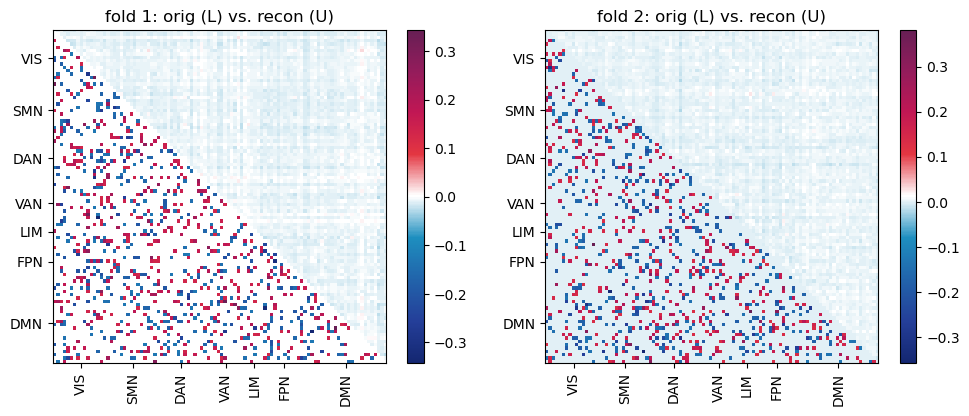

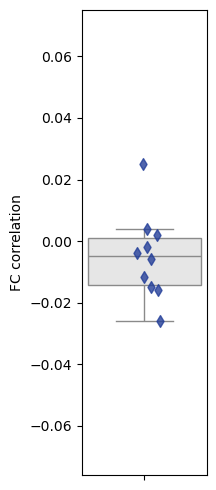

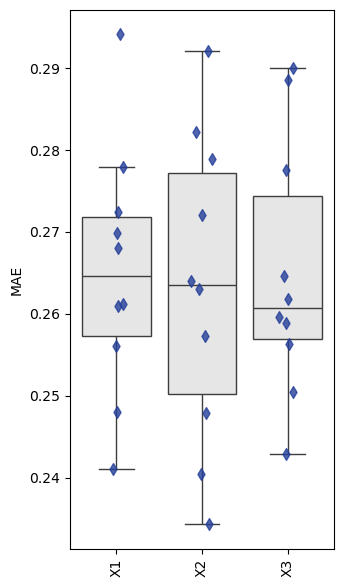

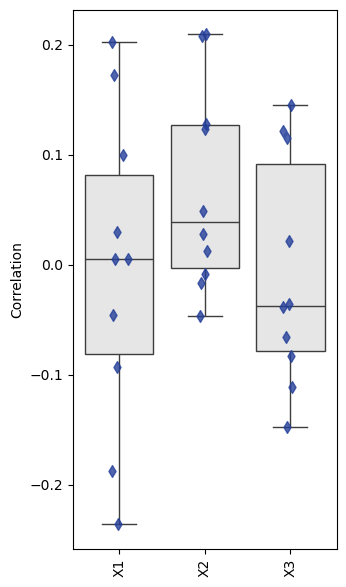

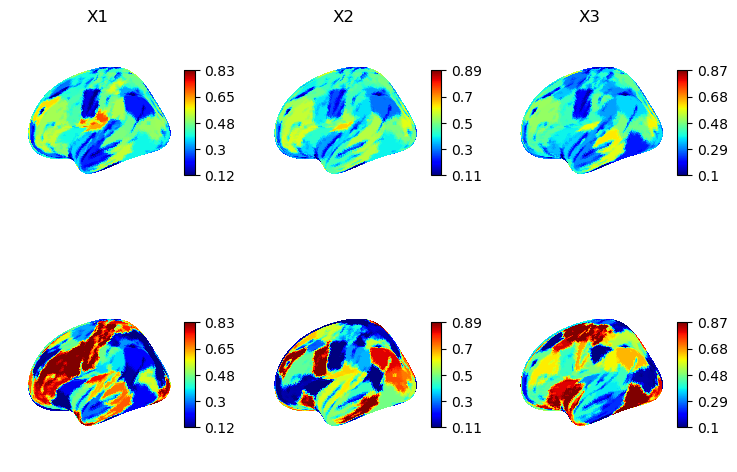

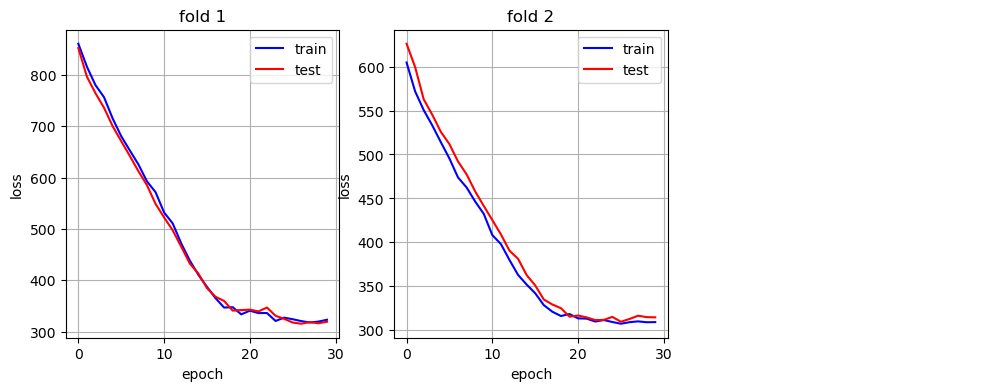

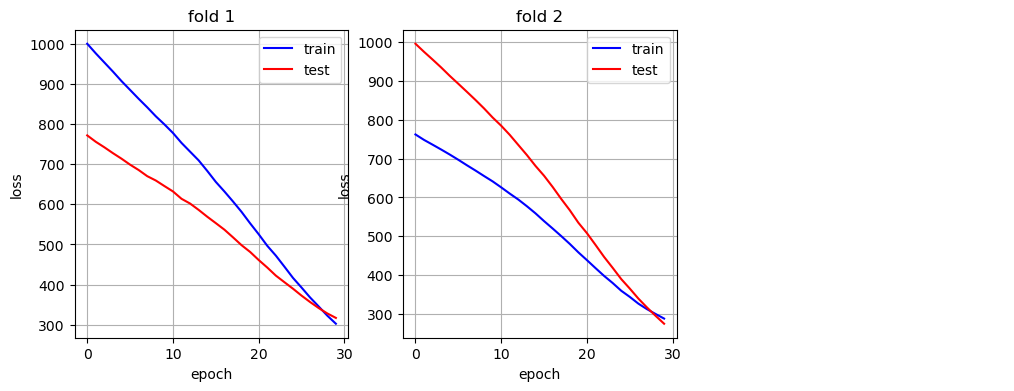

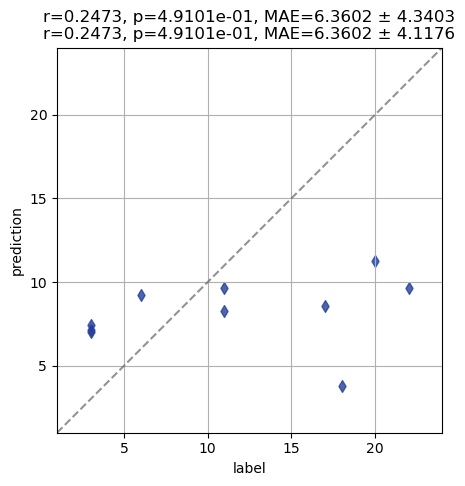

[I] exlogger.train_jointly >> "Completed after 0:00:34"


Experiment completed in 00h 00min 35sec. 
Outputs saved in /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/outputs/demo_run/seed_0.


In [5]:
from utils.configs import load_configs_from_json, fetch_job_config
from utils.files import add_project_root
from experiments.run_experiment import run

config_name = "demo_config.json"
config_id = 0
seed = 0

config_file = add_project_root(os.path.join("experiments", "configs", config_name))
config = fetch_job_config(load_configs_from_json(config_file), config_id)
config["verbose"] = True
config["seed"] = seed
config["save_weights"] = True
output_dir = add_project_root(config.get("output_dir", "outputs/runs/train_jointly/demo_config/"))
config["output_dir"] = os.path.join(output_dir, f"seed_{seed}")

run("train_jointly", "FileStorageObserver", config)
print(f"Training finished. Outputs in {config['output_dir']}.")

The generated plots show VGAE node and edge feature test-reconstructions for one example subject of each CV-fold, boxplots with true-vs-reconstructed correlation (or mean absolute error) for node and edge features, VGAE and MLP loss curves, and the true-vs-predicted MLP predictions. Since we created random data, the results are not very meaningful here. But this is just to demonstrate how our pipeline works and what kind of outputs it generates.

Alternatively, you can run the training from the command line like this (from project root):

```bash
python -m experiments.run_experiment train_jointly FileStorageObserver --config_json=demo_config.json --jobid=0
```

Note that you still need to create and load the BrainGraphDataset before training.